#**UNIDADES: FITME**
	04 de diciembre - 2025

* Paulina Almada Martínez (A01710029)
* Mauricio Benavente Revuelta (A01705898)
* Sol Venecia Ramos Vallejo (A01066646)
* Daniela Isabel Tapia Martínez (A01710768)

##**UNIDADES**

###**Montaje de los DataFrames**

In [64]:
import pandas as pd

In [65]:
combustibles = pd.read_csv('combustibles_clean.csv')

In [66]:
peajes = pd.read_csv('peajes_clean.csv')

In [67]:
telemetria_report = pd.read_csv('telemetria_report_clean.csv')

In [68]:
telemetria_summary = pd.read_csv('telemetria_summary_clean.csv')

In [69]:
viajes = pd.read_csv('viajes_clean.csv')

###**Simulación de Asignación de Unidades**

Importamos las librerías necesarias para poder crear nuestra simulación, evaluar su rendimiento y después entrenar un modelo **RandomForest** a base del mismo.

Con este modelo, primero generamos una simulación donde buscamos la manera más óptima de organizar la flota buscando reducir el ralentí lo más posible. Después, vamos a evaluar si esta simulación logra reducir el ralentí comparado con los datos finales. Finalmente, vamos a utilizar esta simulación para entrenar un RandomForest para predecir el ralentí futuro siguiendo el uso actual de la flota, para comparar el ralentí futuro si se optimizan las rutas a base de nuestra simulación.

In [70]:
from scipy.stats import shapiro
import statsmodels.api as sm
from scipy.stats import levene
from scipy.stats import kruskal
from scipy.stats import ttest_rel, wilcoxon
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

Primero, realizamos una limpieza de datos mínima para asegurar la calidad de nuestro modelo. Esto incluye convertir las métricas de ralentí de telemetría a un formato en horas.

In [71]:
telemetria_report['Fecha_inicio'] = pd.to_datetime(telemetria_report['Fecha de inicio del periodo'])
telemetria_report['Fecha_fin'] = pd.to_datetime(telemetria_report['Fecha de fin del periodo'])

In [72]:
telemetria_report['Tiempo en ralentí'] = pd.to_timedelta(telemetria_report['Tiempo en ralentí'])

In [73]:
telemetria_report['ralenti_h_period'] = telemetria_report['Tiempo en ralentí'].dt.total_seconds() / 3600.0

In [74]:
telemetria_report = telemetria_report.rename(columns={'Nombre':'Unidad'})
viajes = viajes.rename(columns={'Tractocamión':'Unidad'})

Después, generamos nuestro dataframe. donde organizamos los datos de telemetría para tener una fila diaria del uso y ralentí de cada unidad.

In [75]:
# Crear filas diarias por vehículo (expande periodos a filas diarias)
tel_expanded = []
for _, row in telemetria_report.iterrows():
    start = row['Fecha_inicio'].normalize()
    end = row['Fecha_fin'].normalize()
    days = (end - start).days + 1
    if days <= 0:
        continue
    daily_ralenti = row['ralenti_h_period'] / days
    df_days = pd.DataFrame({
        'Unidad': row['Unidad'],
        'date': pd.date_range(start, end, freq='D'),
        'ralenti_h_daily': daily_ralenti
    })
    tel_expanded.append(df_days)
tel_daily = pd.concat(tel_expanded, ignore_index=True)

Después, creamos nuestro dataframe agregado para nuestros operaciones, donde combinamos los datos de viajes con los datos de telemetría para poder asociar el ralentí con las rutas.

In [76]:
# Prepara viajes con fecha normalizada
viajes['Fecha'] = pd.to_datetime(viajes['Fecha']).dt.normalize()

# Estandarizar nombre columna
viajes = viajes.rename(columns={'Tractocamión':'Unidad'})

# Merge viajes con telemetría diaria por unidad+fecha (para ver ralentí asociado a cada viaje)
sk11 = pd.merge(
    viajes,
    tel_daily.rename(columns={'Unidad':'Unidad','date':'Fecha','ralenti_h_daily':'ralenti_h_daily'}),
    left_on=['Unidad','Fecha'],
    right_on=['Unidad','Fecha'],
    how='left'
)

# Si hay NaNs, rellenar con mediana por Ruta o global
ruta_median = sk11.groupby('Ruta')['ralenti_h_daily'].median().rename('ruta_ralenti_med').reset_index()
sk11 = sk11.merge(ruta_median, on='Ruta', how='left')
global_med = tel_daily['ralenti_h_daily'].median()
sk11['ralenti_for_route'] = sk11['ralenti_h_daily'].fillna(sk11['ruta_ralenti_med']).fillna(global_med)

Con esto, ya podemos generar nuestra simulación. Esencialmente:

1. Convertimos los periodos de telemetría en registros diarios por unidad, para saber cuántas horas de ralentí aporta cada camión por día.

2. Unimos los dfs de `viajes` y `telemetría_report`, asignando un valor de ralentí estimado por viaje (imputando con la mediana si no hay datos).

3. Por cada día, obtenemos:

   * la lista de rutas/viajes pendientes
   * la lista de unidades disponibles

4. Ordenamos las rutas del día de mayor a menor ralentí estimado, para atacar primero las rutas con mayor ralentí.

5. Hacemos una reasignación GREEDY, donde a cada viaje se le asigna a la unidad que lleve menos ralentí acumulado ese día, buscando balancear la carga de rutas "caras" (con much ralentí) entre las unidades.

6. Calculamos un escenario final con el ralentí total simulado por día y lo comparamos con el real para estimar la reducción.

In [77]:
# Crear lista de viajes únicos por fecha (o por ventana temporal) que queremos reasignar
# Aquí trabajamos por día: para cada date, tomamos las rutas pendientes y reasignamos a vehículos disponibles ese día.
dates = pd.to_datetime(sk11['Fecha'].dropna().unique())
sim_assignments = []

for d in dates:
    trips_d = sk11[sk11['Fecha']==d].copy()
    if trips_d.empty:
        continue
    units_d = tel_daily[tel_daily['date']==d]['Unidad'].unique()
    if len(units_d)==0:
        # si no hay telemetría ese día, usar todas las unidades conocidas como fallback
        units_d = tel_daily['Unidad'].unique()
        if len(units_d)==0:
            continue

    # inicializar carga por unidad
    load = {u: 0.0 for u in units_d}

    trips_sorted = trips_d.sort_values('ralenti_for_route', ascending=False)
    for _, trip in trips_sorted.iterrows():
        # elegir unidad con menos carga
        chosen = min(load.items(), key=lambda x: x[1])[0]
        prev_unit = trip.get('Unidad')
        sim_assignments.append({
            'Fecha': d,
            'Ruta': trip['Ruta'],
            'OldUnidad': prev_unit,
            'NewUnidad': chosen,
            'ruta_ralenti_est_h': trip['ralenti_for_route']
        })
        load[chosen] += trip['ralenti_for_route']

sim_df = pd.DataFrame(sim_assignments)

In [78]:
# Real: sumar ralenti_h_daily por día (desde telemetría/viajes combinados)
# Use outer merge so we don't drop days that exist only in one source
fleet_daily_actual = (
    sk11.groupby('Fecha', as_index=False)['ralenti_h_daily']
        .sum()
        .rename(columns={'ralenti_h_daily': 'ralenti_total_h'})
)

# Simulado: suma de ralenti estimado por fecha (desde sim_df)
fleet_daily_sim = (
    sim_df.groupby('Fecha', as_index=False)['ruta_ralenti_est_h']
    .sum().rename(columns={'ruta_ralenti_est_h':'ralenti_h_sim'})
)

# Alinear todas las fechas posibles (outer) y rellenar 0 donde falte
df_compare = pd.merge(fleet_daily_actual, fleet_daily_sim, on='Fecha', how='outer').sort_values('Fecha')
df_compare['ralenti_total_h'] = df_compare['ralenti_total_h'].fillna(0.0)
df_compare['ralenti_h_sim'] = df_compare['ralenti_h_sim'].fillna(0.0)

In [79]:
# calcular reduccion por día y totales
df_compare['reduccion'] = df_compare['ralenti_total_h'] - df_compare['ralenti_h_sim']
reduccion_total = df_compare['reduccion'].sum()
reduccion_promedio = df_compare['reduccion'].mean()

print(f"La reducción total fue de {round(reduccion_total, 3)} horas")
print(f"La reducción promedio fue de {round(reduccion_promedio, 3)} horas")

La reducción total fue de -51391.805 horas
La reducción promedio fue de -171.306 horas


Ya que creamos y validamos nuestra simulación, podemos utilizarla para entrenar un modelo para predecir el ralentí en las siguientes semanas de nuestra simulación y compararlo con el ralentí que predecimos se generará en las rutas basado en su distribución actual.

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

TRAIN RMSE: 43.63  TEST RMSE: 168.36
TRAIN R2: 0.984  TEST R2: 0.418


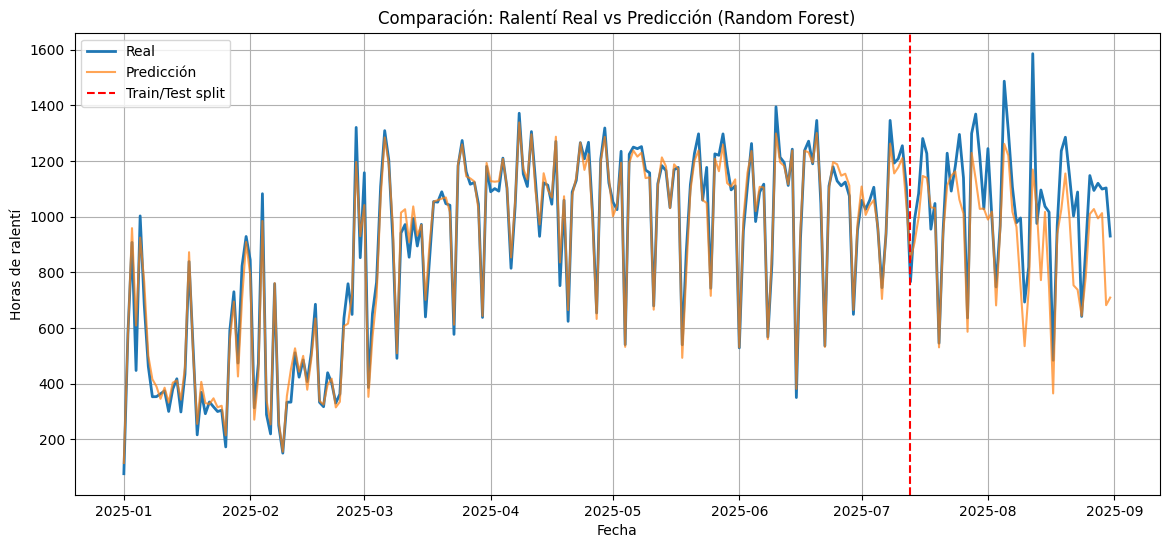

In [81]:
# Obtener viajes diarios
daily_viajes = viajes.groupby('Fecha').agg(
    viajes_dia=('Ruta', 'count'),
    dist_total_dia=('Ruta', 'count'),
    unidades_activas=('Unidad', 'nunique')
).reset_index()

# Merge con el df de ralentí real y simulado
df_full = pd.merge(df_compare, daily_viajes, on='Fecha', how='left')

# Fecha as datetime
df_full['Fecha'] = pd.to_datetime(df_full['Fecha'])

# Obtener día de la semana y mes
df_full['weekday'] = df_full['Fecha'].dt.weekday
df_full['month'] = df_full['Fecha'].dt.month

# Limpieza de datos mínima
df_full = df_full.dropna(subset=['viajes_dia'])
df_full['ralenti_total_h'] = df_full['ralenti_total_h'].replace(0, np.nan)
df_full = df_full.dropna(subset=['ralenti_total_h'])

# Target: ralentí real
y = df_full['ralenti_total_h']

# Entrenar en base al resto
X = df_full[['viajes_dia', 'dist_total_dia', 'unidades_activas', 'weekday', 'month']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # debemos mantener el orden
)

# Generar RandomForest
model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    max_depth=10
)

model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Metrics (use RMSE and R2)
rmse_train = math.sqrt(mean_squared_error(y_train, pred_train))
rmse_test = math.sqrt(mean_squared_error(y_test, pred_test))
r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

print(f"TRAIN RMSE: {rmse_train:.2f}  TEST RMSE: {rmse_test:.2f}")
print(f"TRAIN R2: {r2_train:.3f}  TEST R2: {r2_test:.3f}")

# Para poder generar visualización
df_full.loc[X_train.index, 'pred'] = pred_train
df_full.loc[X_test.index, 'pred'] = pred_test

# Visualización
plt.figure(figsize=(14,6))
plt.plot(df_full['Fecha'], df_full['ralenti_total_h'], label='Real', linewidth=2)
plt.plot(df_full['Fecha'], df_full['pred'], label='Predicción', alpha=0.7)
plt.axvline(df_full['Fecha'].iloc[len(X_train)-1], color='red', linestyle='--', label='Train/Test split')
plt.title("Comparación: Ralentí Real vs Predicción (Random Forest)")
plt.xlabel("Fecha")
plt.ylabel("Horas de ralentí")
plt.legend()
plt.grid(True)
plt.show()

Para dar mayor valor, creamos una matriz de asignación y un sanky de reasignaciones, además de una comparación por unidad de su viejo ralentí vs su nuevo ralentí.

In [82]:
# Contar viajes (o sumatoria de ralenti)
matriz_counts = (
    sim_df
    .groupby(['OldUnidad','NewUnidad'])
    .agg(num_viajes=('Ruta','count'), ralenti_mov=('ruta_ralenti_est_h','sum'))
    .reset_index()
)

# Pivot para mostrar en tabla
matriz_pivot_counts = matriz_counts.pivot_table(
    index='OldUnidad',
    columns='NewUnidad',
    values='ralenti_mov',
    fill_value=0
)

# Añadir nombres más claros y guardar
matriz_pivot_counts.columns.name = None
matriz_pivot_counts = matriz_pivot_counts.reset_index().rename(columns={'OldUnidad':'Unidad (antes)'})

# Crear una tabla explicativa por fila (OldUnidad, NewUnidad, viajes, ralenti_mov, promedio_por_viaje)
matriz_explained = matriz_counts.copy()
matriz_explained['ralenti_prom_por_viaje'] = matriz_explained['ralenti_mov'] / matriz_explained['num_viajes']
matriz_explained = matriz_explained.sort_values(['OldUnidad','ralenti_mov'], ascending=[True,False])

In [83]:
sankey_df = matriz_counts.copy()
units_all = list(pd.Index(sankey_df['OldUnidad']).append(pd.Index(sankey_df['NewUnidad']).unique()).unique())
# create mapping
label_map = {u:i for i,u in enumerate(units_all)}
sankey_sources = sankey_df['OldUnidad'].map(label_map).tolist()
sankey_targets = sankey_df['NewUnidad'].map(label_map).tolist()
sankey_values = sankey_df['ralenti_mov'].tolist()

sankey_fig = go.Figure(data=[go.Sankey(
    node=dict(label=units_all, pad=15, thickness=15),
    link=dict(source=sankey_sources, target=sankey_targets, value=sankey_values)
)])

In [84]:
# Ralenti "antes" por unidad: suma de ralenti asignada históricamente (proxy: suma por OldUnidad)
ralenti_antes = sim_df.groupby('OldUnidad', as_index=False)['ruta_ralenti_est_h'].sum().rename(columns={'OldUnidad':'Unidad','ruta_ralenti_est_h':'ralenti_antes'})

# Ralenti "después" por unidad: suma de ralenti asignada en la nueva asignación (suma por NewUnidad)
ralenti_despues = sim_df.groupby('NewUnidad', as_index=False)['ruta_ralenti_est_h'].sum().rename(columns={'NewUnidad':'Unidad','ruta_ralenti_est_h':'ralenti_despues'})

# Merge para comparar por unidad
impacto_unidades = pd.merge(ralenti_antes, ralenti_despues, on='Unidad', how='outer').fillna(0.0)
impacto_unidades['reduccion_h'] = impacto_unidades['ralenti_antes'] - impacto_unidades['ralenti_despues']
impacto_unidades = impacto_unidades.sort_values('reduccion_h', ascending=True)  # asc para ver increases (negativos) arriba si quieres
impacto_unidades.to_csv("impacto_unidades.csv", index=False)

# Para visualización: crear columna magnitud y signo
impacto_unidades['reduccion_mag'] = impacto_unidades['reduccion_h'].abs()
impacto_unidades['signo'] = np.where(impacto_unidades['reduccion_h'] >= 0, 'reduccion', 'incremento')

### **Guardar resultados para Streamlit**

In [85]:
# Resultados simulación
df_compare.to_csv("df_compare.csv", index=False)

# Asignaciones simulación
sim_df.to_csv("sim_df.csv", index=False)

# Matriz de asignación
matriz_asignacion = sim_df.pivot_table(
    index="OldUnidad",
    columns="NewUnidad",
    values="ruta_ralenti_est_h",
    aggfunc="count",
    fill_value=0
)
matriz_asignacion.to_csv("matriz_asignacion.csv")

# Explicación matriz
matriz_explained.to_csv("matriz_reasignacion_explained.csv", index=False)

# Efecto por unidad
efecto_unidad = sim_df.groupby("NewUnidad")['ruta_ralenti_est_h'].sum() - \
                sk11.groupby("Unidad")['ralenti_for_route'].sum()
efecto_unidad = efecto_unidad.reset_index()
efecto_unidad.columns = ["Unidad", "Reduccion"]
efecto_unidad.to_csv("efecto_por_unidad.csv", index=False)

# Real vs predicho (RandomForest)
df_full.to_csv("df_full.csv", index=False)